In [1]:
import matplotlib.pyplot as plt

import numpy as np

import json
import glob
import sys
import os

sys.path.append('../src')

### Visualization of training loss and test accuracy

In [2]:
with open('../experiments/history/history-AConvNet-CR.json') as f:
    history = json.load(f)

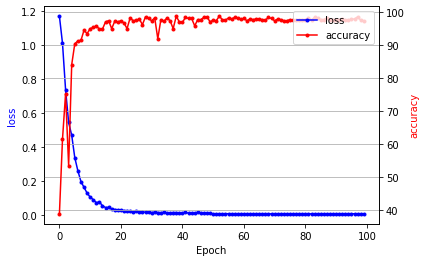

In [3]:
training_loss = history['loss']
test_accuracy = history['accuracy']

epochs = np.arange(len(training_loss))

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

plot1, = ax1.plot(epochs, training_loss, marker='.', c='blue', label='loss')
plot2, = ax2.plot(epochs, test_accuracy, marker='.', c='red', label='accuracy')
plt.legend([plot1, plot2], ['loss', 'accuracy'], loc='upper right')

plt.grid()

ax1.set_xlabel('Epoch')
ax1.set_ylabel('loss', color='blue')
ax2.set_ylabel('accuracy', color='red')
plt.show()


### Early Stopping

In [4]:
from tqdm import tqdm
import torchvision
import torch

from utils import common
from data import preprocess
from data import loader
import model

In [5]:
def load_dataset(path, is_train, name, batch_size):

    _dataset = loader.Dataset(
        path, name=name, is_train=is_train,
        transform=torchvision.transforms.Compose([
            preprocess.CenterCrop(88), torchvision.transforms.ToTensor()
        ])
    )
    data_loader = torch.utils.data.DataLoader(
        _dataset, batch_size=batch_size, shuffle=is_train, num_workers=1
    )
    return data_loader


def evaluate(_m, ds):
    
    num_data = 0
    corrects = 0
    num_confusers = 0
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        num_data += labels.size(0)
        corrects += (predictions == labels.to(m.device)).sum().item()
        num_confusers += (labels >= 3).sum().item() 

    accuracy = 100 * corrects / (num_data - num_confusers)
    return accuracy

In [6]:

config = common.load_config(os.path.join(common.project_root, 'experiments/config/AConvNet-CR.json'))
model_name = config['model_name']
test_set = load_dataset('dataset', False, 'confuser-rejection', 100)

m = model.Model(
    classes=config['num_classes'], channels=config['channels'],
)

model_history = glob.glob(os.path.join(common.project_root, f'experiments/model/{model_name}/*.pth'))
model_history = sorted(model_history, key=os.path.basename)

best = {
    'epoch': 0,
    'accuracy': 0,
    'path': ''
}

for i, model_path in enumerate(model_history):
    m.load(model_path)
    accuracy = evaluate(m, test_set)
    if accuracy > best['accuracy']:
        best['epoch'] = i
        best['accuracy'] = accuracy
        best['path'] = model_path
        print(f'Best accuracy at epoch={i} with {accuracy:.2f}%')
    
best_epoch = best['epoch']
best_accuracy = best['accuracy']
best_path = best['path']

print(f'Final model is epoch={best_epoch} with accurayc={best_accuracy:.2f}%')
print(f'Path={best_path}')

load test data set: 1135it [00:00, 2019.58it/s]
d:\ivs\project\004-research\signal-processing\image-processing\remote-sensing\aconvnet\aconvnet-pytorch\venv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Best accuracy at epoch=0 with 38.67%
Best accuracy at epoch=1 with 61.50%
Best accuracy at epoch=2 with 75.30%
Best accuracy at epoch=4 with 84.16%
Best accuracy at epoch=5 with 90.46%
Best accuracy at epoch=6 with 91.31%
Best accuracy at epoch=7 with 91.48%
Best accuracy at epoch=8 with 94.55%
Best accuracy at epoch=10 with 95.06%
Best accuracy at epoch=11 with 95.40%
Best accuracy at epoch=12 with 95.91%
Best accuracy at epoch=15 with 97.10%
Best accuracy at epoch=16 with 97.44%
Best accuracy at epoch=23 with 98.30%
Best accuracy at epoch=28 with 98.64%
Best accuracy at epoch=38 with 98.81%
Final model is epoch=38 with accurayc=98.81%
Path=D:\ivs\Project\004-research\signal-processing\image-processing\remote-sensing\aconvnet\AConvNet-pytorch\experiments/model/AConvNet-CR\model-039.pth


### Confusion Matrix with Best Model

In [7]:
from sklearn import metrics
from data import mstar

def confusion_matrix(_m, ds):
    _pred = []
    _gt = []
    
    _m.net.eval()
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)

        _, predictions = torch.max(predictions.data, 1)
        labels = labels.type(torch.LongTensor)
        
        _known = labels < 3
        
        _pred += predictions[_known].cpu().tolist()
        _gt += labels[_known].cpu().tolist()
        
    conf_mat = metrics.confusion_matrix(_gt, _pred)
        
    return conf_mat

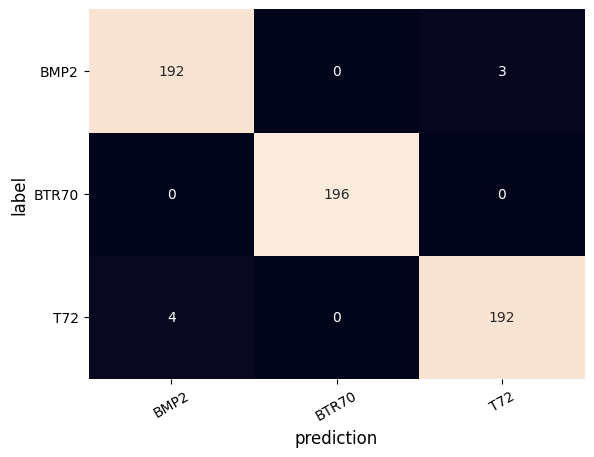

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

m.load(best_path)
_conf_mat = confusion_matrix(m, test_set)

sns.reset_defaults()
ax = sns.heatmap(_conf_mat, annot=True, fmt='d', cbar=False)
ax.set_yticklabels(mstar.target_name_confuser_rejection[:3], rotation=0)
ax.set_xticklabels(mstar.target_name_confuser_rejection[:3], rotation=30)

plt.xlabel('prediction', fontsize=12)
plt.ylabel('label', fontsize=12)


plt.show()

### Confuser Rejection

In [25]:
def confuser_rejection(_m, ds):
        
    num_known = 0
    num_confuser = 0
    
    posteriors = []
    gt = []
    
    _softmax = torch.nn.Softmax(dim=1)
    for i, data in enumerate(ds):
        images, labels, _ = data
        
        is_confuser = labels > 2
        
        num_known += not is_confuser
        num_confuser += is_confuser
        
        predictions = _m.inference(images)
        predictions = _softmax(predictions)
        
        posteriors.append(predictions)
        gt.append(is_confuser)
        
#         print(f'{predictions.cpu().tolist()[0][0]:.2f}, {predictions.cpu().tolist()[0][1]:.2f}, {predictions.cpu().tolist()[0][2]:.2f}')
        
    p_d = []
    p_fa = []
        
    for th in np.arange(0., 1.1, 0.005):
        as_known = 0
        confuser_as_known = 0
        
        for predictions, is_confuser in zip(posteriors, gt):
            as_confuser = predictions < th

            if torch.sum(as_confuser) == 3:
                continue

            if is_confuser:
                confuser_as_known += 1
            else:
                as_known += 1
        
        p_d.append(as_known / num_known)
        p_fa.append(confuser_as_known / num_confuser)
        
    return p_d, p_fa, np.arange(0., 1.1, 0.001)

load test data set: 1135it [00:00, 2238.80it/s]


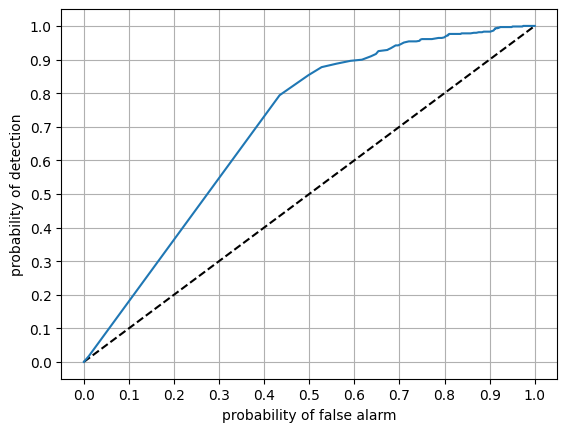

In [26]:

test_set = load_dataset('dataset', False, 'confuser-rejection', 1)
d, fa, th = confuser_rejection(m, test_set)


plt.plot([0, 1], [0, 1], linestyle='--', markersize=0.01, color='black')
plt.plot(fa, d)
plt.xlabel('probability of false alarm')
plt.ylabel('probability of detection')
plt.xticks(np.arange(0., 1.1, 0.1))
plt.yticks(np.arange(0., 1.1, 0.1))
plt.grid(True)
